In [113]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from typing import Union

from matplotlib import ticker
import numpy as np
import json
import country_converter as coco
from datetime import datetime, timedelta
import requests
import pandas as pd
import geopandas as gpd
import scipy.stats as sps

In [165]:
data = pd.read_csv('../dat/tele_and_gov_data.csv')

data_pol = None
for i in range(16):
    data_part = data.iloc[:,i*9+1:i*9+10]
    reg = data_part.columns[0]
    data_part.columns = list(map(lambda x: x[3:] if '_' in x else 'orders', data_part.columns))
    data_part['year'] = data.iloc[:,0]
    data_part['state'] = reg
    data_pol = pd.concat([data_pol, data_part], axis=0) if data_pol is not None else data_part


Data = pd.read_excel('../dat/surveillance_data.xlsx', sheet_name=None)

data_orders = None
for k in Data.keys():
    data_y = Data[k]
    data_y = data_y.groupby('paragraph').sum().T.reset_index()
    data_y['state'] = data_y['index']
    data_y['year'] = int(k[:4])
    data_orders = pd.concat([data_orders, data_y], axis=0) if data_orders is not None else data_y

data_orders.columns = [x if isinstance(x, str) else 'cases_' + str(x) for x in data_orders.columns]


population = pd.read_csv('../dat/12411-0010-DLAND_population.csv')
population = pd.melt(population, id_vars=['state'], value_vars=population.columns[1:])
population.columns = ['state', 'year', 'population']
population['year'] = population.year.astype('int64')

data = data_pol.merge(data_orders, on=['state', 'year']).merge(population, on=['state', 'year'])

data[['Reg1', 'Reg2', 'Reg3']] = data[['Reg1', 'Reg2', 'Reg3']].replace(['0', 0], '')
data['parties'] = (data.Reg1 
                   + ' ' + data.Reg2
                   + ' ' + data.Reg3).apply(lambda x: tuple(sorted(x.split())))

data['case_4_proba'] = data.cases_4 / data.population

data.head()

,orders,AfD,CDU,Grüne,Linke,Reg1,Reg2,Reg3,SPD,year,state,index,cases_3,cases_4,cases_5,cases_6,population,parties,case_4_proba
0,289,0.0,19.8,5.6,27.2,SPD,Linke,,33.0,2013,BB,BB,104,289,314,289,2449193,"(Linke, SPD)",0.000118
1,301,12.2,23.0,6.2,18.6,SPD,Linke,,31.9,2016,BB,BB,113,288,1580,288,2494648,"(Linke, SPD)",0.000115
2,136,23.5,15.6,10.8,10.7,SPD,Grüne,CDU,26.2,2019,BB,BB,76,136,10,181,2521893,"(CDU, Grüne, SPD)",0.000054
3,267,23.5,15.6,10.8,10.7,SPD,Grüne,CDU,26.2,2020,BB,BB,90,267,0,268,2531071,"(CDU, Grüne, SPD)",0.000105
4,207,23.5,15.6,10.8,10.7,SPD,Grüne,CDU,26.2,2021,BB,BB,81,207,0,207,2537868,"(CDU, Grüne, SPD)",0.000082


In [166]:
data.query('year==2021')[['AfD', 'CDU', 'Grüne', 'Linke', 'case_4_proba']].corr()['case_4_proba']

AfD            -0.328368
CDU            -0.247763
Grüne           0.581077
Linke          -0.158786
case_4_proba    1.000000
Name: case_4_proba, dtype: float64

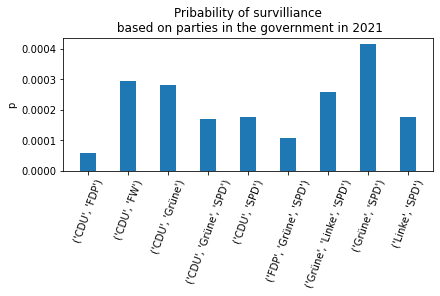

In [343]:
parties_grouped = data.query('year==2021').groupby('parties').sum()[['cases_4', 'population']]
parties_grouped['p'] = parties_grouped.cases_4/parties_grouped.population

fig, ax = plt.subplots(layout='constrained')

width = 0.4
x = np.arange(len(parties_grouped))
offset = 0.01

rect1 = ax.bar(x, parties_grouped.p, width)

# ax.set_xlabel('party')
ax.set_ylabel('p')
ax.set_title('Pribability of survilliance\n based on parties in the government in 2021')
ax.set_xticks(x, parties_grouped.index, rotation=70)
# ax.legend(loc='upper left')

plt.show()

In [338]:
def Wald_test_Bern(n1: int, p1: float, n2: int, p2: float, how: str = 'two-sided'):
    """
    ...
    """
    assert how in ('two-sided', 'greater', 'less'), 'how is not defined'
    if n1 * n2 * (p1 + p2) == 0 :
        return None
    D = p1 * (1 - p1) / n1 + p2 * (1 - p2) / n2 
    W = (p2 - p1) / D**(1/2)
    if how == 'two-sided':
        p = 2 * sps.norm.sf(abs(W))
    elif how == 'greater':
        p = sps.norm.sf(W)
    elif how == 'less':
        p = sps.norm.cdf(W)
    
    return round(W, 2), round(p, 5)
    

def stats_party(data, party):
    party_idx = data.parties.apply(lambda x: party in x)
    h1, n1 = data[~party_idx].sum()[['cases_4', 'population']]
    h2, n2 = data[party_idx].sum()[['cases_4', 'population']]
    p1, p2 = round(h1/n1, 6), round(h2/n2, 6)
    return n1, p1, n2, p2 

parties = ['Linke', 'SPD', 'CDU', 'Grüne', 'FW', 'FDP']

d = {k: [] for k in ('party', 'p_absent', 'n_absent', 'p_present', 'n_present', 'W', 'p_value')}

for party in parties:
    n1, p1, n2, p2 = stats_party(data.query('year==2021'), party)
    W, p = Wald_test_Bern(n1, p1, n2, p2)
    for k, v in zip(d.keys(), (party, p1, n1, p2, n2, W, p)):
        d[k].append(v)

pd.DataFrame(d)

,party,p_absent,n_absent,p_present,n_present,W,p_value
0,Linke,0.000194,75163166,0.000242,8073958,8.41,0.00000
1,SPD,0.000202,48521239,0.000193,34715885,-2.89,0.00389
2,CDU,0.000225,14034378,0.000193,69202746,-7.38,0.00000
3,Grüne,0.000162,41722119,0.000235,41515005,23.63,0.00000
4,FW,0.000181,70060135,0.000294,13176989,22.65,0.00000
5,FDP,0.000246,61206048,0.000067,22031076,-67.37,0.00000


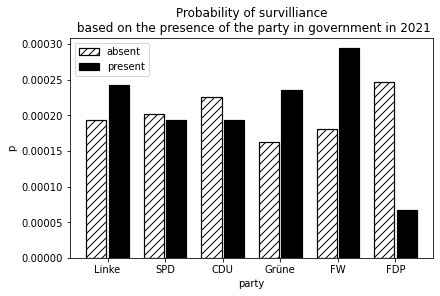

In [369]:
fig, ax = plt.subplots(layout='constrained')

width = 0.35
x = np.arange(len(parties))
offset = 0.02

party_p = pd.DataFrame(d)

# plt.rcParams['hatch.linewidth'] = 0.5

style = {'edgecolor':'black', 'linewidth':1.2}
rect1 = ax.bar(x-width/2-offset, party_p.p_absent, width, label = 'absent', color='white', hatch= '///', **style)
rect3 = ax.bar(x+width/2+offset, party_p.p_present, width, label = 'present', color='black', **style)

ax.set_xlabel('party')
ax.set_ylabel('p')
ax.set_title('Probability of survilliance\n based on the presence of the party in government in 2021')
ax.set_xticks(x, party_p.party)
ax.legend(loc='upper left')

plt.show()